In [2]:
def get_info(xml_path):
    tree = ET.parse(str(xml_path))
    image_info = {'image_name': tree.find('filename').text,
                  'height': int(tree.find('size').find('height').text),
                  'width': int(tree.find('size').find('width').text),
                  'depth': int(tree.find('size').find('depth').text)}
    label_info = []
    objects = tree.findall('object')
    for obj in objects:
        bndbox = obj.find('bndbox')
        bbox = np.int32([bndbox.find('xmin').text,
                        bndbox.find('ymin').text,
                        bndbox.find('xmax').text,
                        bndbox.find('ymax').text])
        label = obj.find('name').text
        label_info.append({'label': label, 'bbox': bbox})
    return image_info, label_info

In [3]:
import os
import cv2
import numpy as np
from pathlib import Path
import xml.etree.ElementTree as ET

mask_dir = Path('./VOC2007/Annotations/')
image_dir = Path('./VOC2007/JPEGImages/')
xml_paths = list(mask_dir.glob('*.xml'))

In [1]:
import cv2
import torch
import random
import numpy as np
from pathlib import Path
from natsort import natsorted
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage


class VOCDataset(Dataset):
    def __init__(self, image_dir, label_dir, image_pattern, label_pattern, classes, transforms=None):
        super(VOCDataset, self).__init__()
        self.classes = classes
        self.transforms = transforms if transforms else []
        image_paths = natsorted(list(Path(image_dir).glob(f'{image_pattern}')), key=lambda x: str(x.stem))
        label_paths = natsorted(list(Path(label_dir).glob(f'{label_pattern}')), key=lambda x: str(x.stem))
        self.data_pairs = [[image, label] for image, label in zip(image_paths, label_paths)]
    
    def __len__(self):
        return len(self.data_pairs)
    
    def _get_label_info(self, label_path):
        tree = ET.parse(str(label_path))
        image_info = {'image_name': tree.find('filename').text,
                      'height': int(tree.find('size').find('height').text),
                      'width': int(tree.find('size').find('width').text),
                      'depth': int(tree.find('size').find('depth').text)}
        label_info = []
        objects = tree.findall('object')
        for obj in objects:
            bndbox = obj.find('bndbox')
            bbox = np.int32([bndbox.find('xmin').text,
                             bndbox.find('ymin').text,
                             bndbox.find('xmax').text,
                             bndbox.find('ymax').text])
            label_name = obj.find('name').text
            label_info.append({'label': label_name, 'bbox': bbox})

        return image_info, label_info

    def __getitem__(self, idx):
        image_path, label_path = self.data_pairs[idx]
        sample_info, label_info = self._get_label_info(label_path)
        sample = cv2.imread(str(image_path))
        boxes = [label['bbox'] for label in label_info]
        labels = [self.classes[label['label']] for label in label_info]

        bbs = BoundingBoxesOnImage([BoundingBox(x1=box[0], y1=box[1], x2=box[2], y2=box[3], label=label)
                                    for box, label in zip(boxes, labels)], shape=sample.shape)
        for transform in random.sample(self.transforms, k=random.randint(0, len(self.transforms))):
            sample, bbs = transform(image=sample, bounding_boxes=bbs)

        boxes = [[bb.x1, bb.y1, bb.x2, bb.y2] for bb in bbs.bounding_boxes]
        labels = [bb.label for bb in bbs.bounding_boxes]

        # Convert to Torch Tensor
        labels = torch.from_numpy(np.asarray(labels)).to(torch.int64)
        boxes = torch.from_numpy(np.asarray(boxes)).to(torch.float32)
        areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        image_id = torch.tensor([idx])

        # Target
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = image_id
        target['area'] = areas

        # Image
        sample = np.ascontiguousarray(sample)
        sample = torch.from_numpy(sample)
        sample = sample.permute(2, 0, 1).to(torch.float)
        sample = (sample - sample.mean()) / sample.std()

        return sample, target, sample_info

In [2]:
import imgaug.augmenters as iaa

label_dir = './VOC2007/Annotations/'
image_dir = './VOC2007/JPEGImages/'
image_pattern = '*.jpg'
label_pattern = '*.xml'
classes2idx = {'chair': 1,
           'car': 2,
           'horse': 3,
           'person': 4,
           'bicycle': 5,
           'cat': 6,
           'dog': 7,
           'train': 8,
           'aeroplane': 9,
           'diningtable': 10,
           'tvmonitor': 11,
           'bird': 12,
           'bottle': 13,
           'sheep': 14,
           'cow': 15,
           'boat': 16, 
           'sofa': 17,
           'pottedplant': 18,
           'motorbike': 19,
           'bus': 20}
transforms = [iaa.Rotate(90)]
voc_set = VOCDataset(image_dir=image_dir,
                     label_dir=label_dir,
                     image_pattern=image_pattern,
                     label_pattern=label_pattern,
                     classes=classes2idx,
                     transforms=transforms)
from torch.utils.data import DataLoader
voc_loader = DataLoader(voc_set, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [3]:
for i in voc_loader:
    
    print(i)

TypeError: 'DataLoader' object is not subscriptable

In [12]:
import matplotlib.pyplot as plt
voc_iter = iter(voc_loader)
samples, targets, sample_infos = next(voc_iter)
for sample, target in zip(samples, targets):
    image = (((sample - sample.min()) / (sample.max() - sample.min())) * 255.).permute(1, 2, 0).to(torch.uint8).numpy()
    boxes = target['boxes']
    labels = target['labels']
    for box in boxes:
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(0, 255, 0), thickness=1)
    cv2.imshow('image', image)
    cv2.waitKey()
    cv2.destroyAllWindows()

In [12]:
import matplotlib.pyplot as plt

sample, target, sample_info = voc_set[10]
print(target)
image = (sample - sample.min()) / (sample.max() - sample.min())
boxes = target['boxes']
labels = target['labels']
for box in boxes:
    cv2.rectangle(image, tuple(box[:2]), tuple(box[2:]), color=(0, 255, 0), thickness=3)
plt.imshow(image)
idx2classes = {idx: cls for cls, idx in classes.items()}
print([idx2classes[label] for label in aug_labels])

{'boxes': tensor([[170.5000, 113.5000, 252.5000, 406.5000]]), 'labels': tensor([8]), 'image_id': tensor([10]), 'area': tensor([24026.])}


TypeError: argument for rectangle() given by name ('color') and position (3)

In [3]:
# np.random.shuffle(xml_paths)
# for xml_path in xml_paths:
#     image_info, label_info = get_info(xml_path)
#     image = cv2.imread(str(image_dir.joinpath(image_info['image_name'])))
#     for info in label_info:
#         b = np.random.randint(0, 255)
#         g = np.random.randint(100, 255)
#         r = np.random.randint(0, 150)
#         cv2.rectangle(image, tuple(info['bbox'][:2]), tuple(info['bbox'][2:]), color=(b, g, r), thickness=3)
#         cv2.putText(image, info['label'], org=tuple(info['bbox'][:2]),
#                     fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1,
#                     color=(b, g, r), thickness=2, lineType=cv2.LINE_AA)
#     cv2.imshow('annotation', image)
#     cv2.waitKey()
#     cv2.destroyAllWindows()

In [4]:
from collections import Counter
import xml.etree.ElementTree as ET

classes = []
for xml_path in xml_paths:
    tree = ET.parse(str(xml_path))
    objects = tree.findall('object')
    for obj in objects:
        classes.append(obj.find('name').text)

classes = dict(Counter(classes))
print(classes)
print('\nnum_classes: {}'.format(len(list(classes.keys()))))

{'chair': 1432, 'car': 1644, 'horse': 406, 'person': 5447, 'bicycle': 418, 'cat': 389, 'dog': 538, 'train': 328, 'aeroplane': 331, 'diningtable': 310, 'tvmonitor': 367, 'bird': 599, 'bottle': 634, 'sheep': 353, 'cow': 356, 'boat': 398, 'sofa': 425, 'pottedplant': 625, 'motorbike': 390, 'bus': 272}

num_classes: 20


### RESIZE

In [495]:
etree = ET.parse(str(xml_paths[0]))
image = cv2.imread(str(image_dir.joinpath(etree.find('filename').text)))
boxes = np.int32([[obj.find('bndbox').find('xmin').text,
                   obj.find('bndbox').find('ymin').text,
                   obj.find('bndbox').find('xmax').text,
                   obj.find('bndbox').find('ymax').text] for obj in etree.findall('object')])

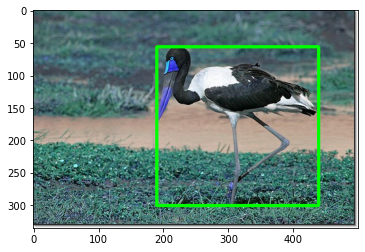

In [498]:
for box in boxes:
    cv2.rectangle(image, tuple(box[:2]), tuple(box[2:]), color=(0, 255, 0), thickness=3)
plt.imshow(image)

In [499]:
class Resize():
    def __init__(self, height=None, width=None):
        self.height = height
        self.width = width
    
    def __call__(self, image, boxes):
        h, w = image.shape[:2]
        boxes = np.int32(boxes)
        if self.height and self.width is None:
            h_, w_ = self.height, int(w * self.height / h)
            image = cv2.resize(image, dsize=(w_, h_), interpolation=cv2.INTER_LINEAR)
        elif self.width and self.height is None:
            h_, w_ = int(h * width / w), w
            image = cv2.resize(image, dsize=(w_, h_), interpolation=cv2.INTER_LINEAR)
        elif self.width and self.height:
            h_, w_ = self.height, self.width
            image = cv2.resize(image, dsize=(w_, h_), interpolation=cv2.INTER_LINEAR)
        else:
            h_, w_ = h, w
        rh, rw = h_ / h, w_ / w
        boxes[:, [0, 2]] = boxes[:, [0, 2]] * rw
        boxes[:, [1, 3]] = boxes[:, [1, 3]] * rh
        return image, boxes

In [500]:
image_, boxes_ = Resize(height=1000, width=1000)(image, boxes)

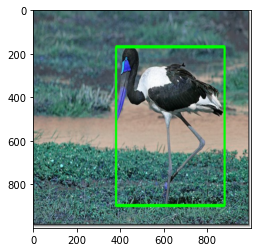

In [502]:
for box in boxes_:
    cv2.rectangle(image_, tuple(box[:2]), tuple(box[2:]), color=(0, 255, 0), thickness=3)
plt.imshow(image_)

### FLIP

In [475]:
class Flip():
    def __init__(self, mode=0):
        self.mode = mode

    def __call__(self, image, boxes):
        boxes = np.int32(boxes)
        bbs, img = boxes.copy(), image.copy()
        cx, cy = img.shape[1] // 2, img.shape[0] // 2
        if self.mode == 0:
            img = img[:, ::-1, :]
            bbs[:, [0, 2]] = 2 * cx - boxes[:, [0, 2]]
        elif self.mode == 1:
            img = img[::-1, :, :]
            bbs[:, [1, 3]] = 2 * cy - boxes[:, [1, 3]]
        elif self.mode == -1:
            img = img[::-1, ::-1, :]
            bbs[:, [0, 2]] = 2 * cx - boxes[:, [0, 2]]
            bbs[:, [1, 3]] = 2 * cy - boxes[:, [1, 3]]
            bbs[:, [0, 1, 2, 3]] = bbs[:, [2, 3, 0, 1]]

        return img.astype(np.uint8), bbs

In [476]:
etree = ET.parse(str(xml_paths[0]))
img_ = cv2.imread(str(image_dir.joinpath(etree.find('filename').text)))
bbs_ = np.int32([[obj.find('bndbox').find('xmin').text,
                   obj.find('bndbox').find('ymin').text,
                   obj.find('bndbox').find('xmax').text,
                   obj.find('bndbox').find('ymax').text] for obj in etree.findall('object')])

In [482]:
image_, boxes_ = Flip(mode=1)(img_, bbs_)

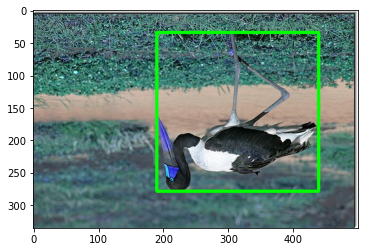

In [483]:
for box in boxes_:
    image_ = cv2.rectangle(image_, tuple(box[:2]), tuple(box[2:]), color=(0, 255, 0), thickness=3)

plt.imshow(image_)

### ROTATION

In [428]:
class Rotation():
    def __init__(self, angle, scale):
        self.angle = angle
        self.scale = scale

    def _get_box_corners(self, boxes):
        ws = (boxes[:, 2] - boxes[:, 0]).reshape(-1, 1)
        hs = (boxes[:, 3] - boxes[:, 1]).reshape(-1, 1)
        x1, y1 = boxes[:, 0].reshape(-1, 1), boxes[:, 1].reshape(-1, 1)
        x2, y2 = x1 + ws, y1
        x3, y3 = boxes[:, 2].reshape(-1, 1), boxes[:, 3].reshape(-1, 1)
        x4, y4 = x1, y1 + hs
        corners = np.concatenate((x1, y1, x2, y2, x3, y3, x4, y4), axis=1)

        return corners
    
    def _get_rotation_matrix2D(self, pts, angle, scale):
        cx, cy = pts
        angle = angle * np.pi / 180.
        # translate center of image to origin
        MT1 = np.float32([[1, 0, -cx],
                          [0, 1, -cy],
                          [0, 0, 1]])
        # rotate image
        MR = np.float32([[np.cos(angle), -np.sin(angle), 0],
                         [np.sin(angle), np.cos(angle), 0],
                         [0, 0, 1]])
        # translate center of image to original position
        MT2 = np.float32([[1, 0, cx],
                          [0, 1, cy],
                          [0, 0, 1]])
        # scale image
        MS = np.float32([[scale, 0, 0],
                         [0, scale, 0],
                         [0, 0, 1]])
        # get matrix transformation
        M = MT2 @ (MS @ (MR @ MT1))  # 3x3

        return M[:2, :]  # 2x3

    def __call__(self, image, boxes):
        h, w = image.shape[:2]

        M = self._get_rotation_matrix2D(pts=(w // 2, h // 2), angle=self.angle, scale=self.scale)

        # expand image
        cos, sin = np.abs(M[0, 0]), np.abs(M[1, 0]) # note!!! using abs why???
        nw = int((h * sin) + (w * cos))
        nh = int((h * cos) + (w * sin))
        M[0, 2] += (nw / 2) - w // 2
        M[1, 2] += (nh / 2) - h // 2

        image = cv2.warpAffine(image.copy(), M, (nw, nh))

        corners = self._get_box_corners(boxes).reshape(-1, 2)
        corners = np.concatenate((corners, np.ones(shape=(corners.shape[0], 1), dtype=type(corners))), axis=1)
        corners = (np.dot(M, corners.T).T).reshape(-1, 8)

        boxes = np.zeros(shape=(corners.shape[0], 4))
        boxes[:, 0] = np.min(corners[:, [0, 2, 4, 6]], axis=1)
        boxes[:, 1] = np.min(corners[:, [1, 3, 5, 7]], axis=1)
        boxes[:, 2] = np.max(corners[:, [0, 2, 4, 6]], axis=1)
        boxes[:, 3] = np.max(corners[:, [1, 3, 5, 7]], axis=1)

        return image, np.int32(boxes)

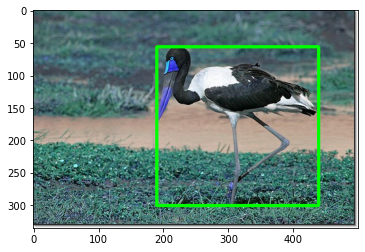

In [432]:
etree = ET.parse(str(xml_paths[0]))
img = cv2.imread(str(image_dir.joinpath(etree.find('filename').text)))
bbs = np.int32([[obj.find('bndbox').find('xmin').text,
               obj.find('bndbox').find('ymin').text,
               obj.find('bndbox').find('xmax').text,
               obj.find('bndbox').find('ymax').text] for obj in etree.findall('object')])

for box in bbs:
    cv2.rectangle(img, tuple(box[:2]), tuple(box[2:]), color=(0, 255, 0), thickness=3)
plt.imshow(img)

In [433]:
image, boxes = Rotation(angle=-45, scale=2)(img, bbs)

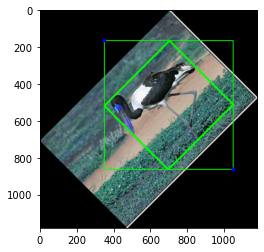

In [434]:
import matplotlib.pyplot as plt
for box in boxes:
    cv2.rectangle(image, tuple(box[:2]), tuple(box[2:]), color=(0, 255, 0), thickness=3)
    cv2.circle(image, tuple(box[:2]), radius=10, color=(0, 0, 255), thickness=-1)
    cv2.circle(image, tuple(box[2:]), radius=10, color=(0, 0, 255), thickness=-1)
plt.imshow(image)

### SHEAR

In [551]:
class Shear():
    def __init__(self, angle_x=None, angle_y=None):
        self.angle_x = angle_x
        self.angle_y = angle_y

    def _get_box_corners(self, boxes):
        ws = (boxes[:, 2] - boxes[:, 0]).reshape(-1, 1)
        hs = (boxes[:, 3] - boxes[:, 1]).reshape(-1, 1)
        x1, y1 = boxes[:, 0].reshape(-1, 1), boxes[:, 1].reshape(-1, 1)
        x2, y2 = x1 + ws, y1
        x3, y3 = boxes[:, 2].reshape(-1, 1), boxes[:, 3].reshape(-1, 1)
        x4, y4 = x1, y1 + hs
        corners = np.concatenate((x1, y1, x2, y2, x3, y3, x4, y4), axis=1)

        return corners
    
    def _get_shear_matrix2D(self, pts, angle_x, angle_y):
        cx, cy = pts
        MT1 = np.float32([[1, 0, -cx],
                          [0, 1, -cy],
                          [0, 0, 1]])
        MT2 = np.float32([[1, 0, cx],
                          [0, 1, cy],
                          [0, 0, 1]])
        if angle_x is not None and angle_x != 0:
            angle_x = angle_x * np.pi / 180.
            MSx = np.float32([[1, np.cos(angle_x) / np.sin(angle_x), 0],
                              [0, 1, 0],
                              [0, 0, 1]])
        if angle_y is not None and angle_y != 0:
            angle_y = angle_y * np.pi / 180.
            MSy = np.float32([[1, 0, 0],
                              [np.cos(angle_y) / np.sin(angle_y), 1, 0],
                              [0, 0, 1]])

        if angle_x and angle_y is None:
            M = (MT2 @ (MSx @ MT1))[:2, :]
        elif angle_y and angle_x is None:
            M = (MT2 @ (MSy @ MT1))[:2, :] 
        elif angle_x and angle_y:
            M = (MT2 @ (MSy @ (MSx @ MT1)))[:2, :]
        else:
            M = None

        return M

    def __call__(self, image, boxes):
        h, w = image.shape[:2]

        M = self._get_shear_matrix2D(pts=(w // 2, h // 2), angle_x=self.angle_x, angle_y=self.angle_y)
        
        if M is not None:
            cos, sin = np.abs(M[0, 0]), np.abs(M[1, 0]) # note!!! using abs why???
            nw = int((h * sin) + (w * cos))
            nh = int((h * cos) + (w * sin))
            M[0, 2] += (nw / 2) - w // 2
            M[1, 2] += (nh / 2) - h // 2

            image = cv2.warpAffine(image.copy(), M, (nw, nh))

            corners = self._get_box_corners(boxes).reshape(-1, 2)
            corners = np.concatenate((corners, np.ones(shape=(corners.shape[0], 1), dtype=type(corners))), axis=1)
            corners = (np.dot(M, corners.T).T).reshape(-1, 8)

            boxes = np.zeros(shape=(corners.shape[0], 4))
            boxes[:, 0] = np.min(corners[:, [0, 2, 4, 6]], axis=1)
            boxes[:, 1] = np.min(corners[:, [1, 3, 5, 7]], axis=1)
            boxes[:, 2] = np.max(corners[:, [0, 2, 4, 6]], axis=1)
            boxes[:, 3] = np.max(corners[:, [1, 3, 5, 7]], axis=1)

        return image, np.int32(boxes)

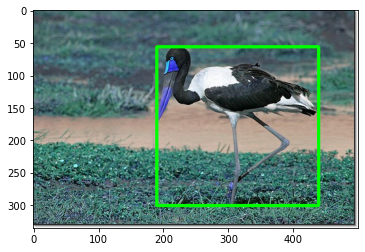

In [552]:
etree = ET.parse(str(xml_paths[0]))
img = cv2.imread(str(image_dir.joinpath(etree.find('filename').text)))
bbs = np.int32([[obj.find('bndbox').find('xmin').text,
               obj.find('bndbox').find('ymin').text,
               obj.find('bndbox').find('xmax').text,
               obj.find('bndbox').find('ymax').text] for obj in etree.findall('object')])

for box in bbs:
    cv2.rectangle(img, tuple(box[:2]), tuple(box[2:]), color=(0, 255, 0), thickness=3)
plt.imshow(img)

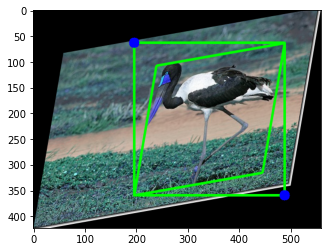

In [558]:
image, boxes = Shear(angle_x=-80, angle_y=-80)(img, bbs)
for box in boxes:
    cv2.rectangle(image, tuple(box[:2]), tuple(box[2:]), color=(0, 255, 0), thickness=3)
    cv2.circle(image, tuple(box[:2]), radius=10, color=(0, 0, 255), thickness=-1)
    cv2.circle(image, tuple(box[2:]), radius=10, color=(0, 0, 255), thickness=-1)
plt.imshow(image)

# IMGAUG

In [422]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

In [505]:
etree = ET.parse(str(xml_paths[0]))
img = cv2.imread(str(image_dir.joinpath(etree.find('filename').text)))
bbs = np.int32([[obj.find('bndbox').find('xmin').text,
               obj.find('bndbox').find('ymin').text,
               obj.find('bndbox').find('xmax').text,
               obj.find('bndbox').find('ymax').text] for obj in etree.findall('object')])
image = img
bbs = BoundingBoxesOnImage([
    BoundingBox(x1=bb[0], y1=bb[1], x2=bb[2], y2=bb[3]) for bb in bbs], shape=image.shape)

In [519]:
seq = iaa.Sequential([
#     iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
    iaa.Affine(rotate=(45),fit_output=True),
    iaa.Fliplr(p=1),
#     iaa.Resize(size=1000),
#     iaa.Affine(shear=(30))
])

image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

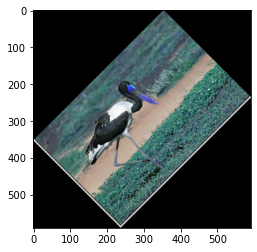

In [520]:
plt.imshow(image_aug)

In [521]:
for bb in bbs_aug:
    box = np.int32([bb.x1, bb.y1, bb.x2, bb.y2])
    cv2.rectangle(image_aug, tuple(box[:2]), tuple(box[2:]), color=(0, 255, 0), thickness=3)

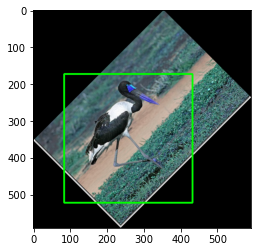

In [522]:
plt.imshow(image_aug)

In [8]:
etree = ET.parse(str(xml_paths[0]))
img = cv2.imread(str(image_dir.joinpath(etree.find('filename').text)))
bbs = np.int32([[obj.find('bndbox').find('xmin').text,
               obj.find('bndbox').find('ymin').text,
               obj.find('bndbox').find('xmax').text,
               obj.find('bndbox').find('ymax').text] for obj in etree.findall('object')])

In [9]:
import numpy as np
import matplotlib.pyplot as plt

img = np.rot90(img, k=1)

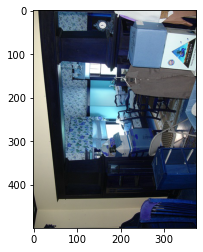

In [10]:
plt.imshow(img)

In [ ]:
cv2.getRotationMatrix2D(())